In [20]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import glob
import sys
import pickle
from scipy import interpolate ,optimize
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm_notebook as tqdm#from tqdm import tqdm
#look at fixing later 
import warnings
warnings.filterwarnings('ignore')

#import functions from file in path 
sys.path.insert(0, '/home/ben/Documents/Bonn-uni/internship/python_code/functions')
#from functions2 import MS_finder2
from data_loading import load_masses, load_models, read_dat2file
#sys.path.insert(0, '/home/ben/Documents/Bonn-uni/internship/python_code/Interpolation')
from interpolation import M_V_T_interp, MVT_interp_setup #, v_over_vcrit_interp

data_dir='/home/ben/Documents/Bonn-uni/internship/takeaway_data/' #'/users/bhastings/internship/data/MW/' # #


In [2]:
data_files, mass_list= load_masses(data_dir, 25)

data_df=load_models(data_files)

vmax_dict={}
for m in mass_list:
    di=data_df[data_df.M == m ]
    vmax=np.unique(di['V']).max()
    #print di['V_init'][di['V']== vmax].iloc[0], m
    vmax_dict[m]=di['V_init'][di['V']== vmax].iloc[0]
    
print data_df.columns.tolist()
    

masses of models :
[ 3.  5.  7.  9. 10. 12. 15. 20. 25.]
working on file 112 / 112['1:t[s]', '2:M/Msun', '3:Teff[K]', '4:log(L/Lsun)', '5:R/Rsun', '6:log(Mdot)[Msun/yr]', '8:v_crit[km/s]', '9:v_surf[km/s]', '11:H', '12:He', '26:H_massfr', '27:He_massfr', 'V/Vcrit', 't/Tms', 'V_init', 'M', 'V', 'T_MS', 'V/Vc_initial']


In [3]:
v_T_interp= MVT_interp_setup(data_df, mass_list)

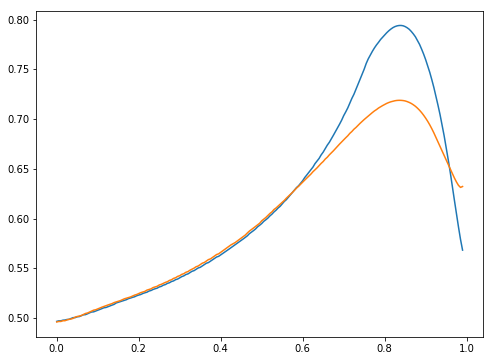

In [28]:
s1=v_over_vcrit_interp2(data_df, 12, 0.5, v_T_interp, False)
s2=v_over_vcrit_interp2(data_df, 15, 0.5, v_T_interp, False)

plt.plot(s2['t/T'], s2['V/Vcrit'], label= s2['M'].iloc[0])
plt.plot(s1['t/T'], s1['V/Vcrit'], label= s1['M'].iloc[0])
plt.show()

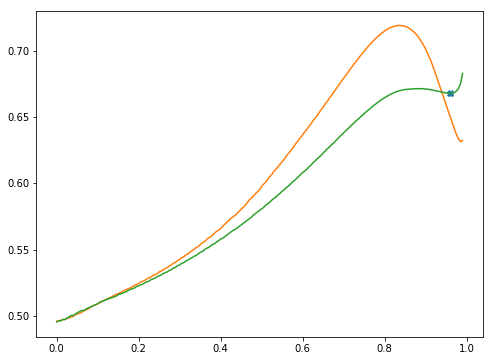

In [16]:
from scipy.signal import argrelextrema
ix=argrelextrema(np.array(s1['V/Vcrit']), np.less)    
plt.plot(s1['t/T'].iloc[ix], s1['V/Vcrit'].iloc[ix], 'X')

plt.plot(s2['t/T'], s2['V/Vcrit'], label= s2['M'].iloc[0])
plt.plot(s1['t/T'], s1['V/Vcrit'], label= s1['M'].iloc[0])
plt.show()

In [5]:
def v_over_vcrit_interp2(data_df, m_i, v_init, v_T_interp_obj, plot):
    '''takes a m_i on the grid and a velocity v_init not on the grid and produces by 
    interpolation the v/vcrit against t or t/T curve'''
    v_T_interp=v_T_interp_obj[0]
    mass_list= v_T_interp_obj[1]
    plot_df=pd.DataFrame()
    dm=data_df[data_df.M ==m_i]
   

    for t_frac in np.linspace(0,0.99, 199):
        dg=pd.DataFrame()
        for vi in np.unique(dm['V_init'])[1:]:
            di= dm[(dm['V_init']==vi)  ]
            ti=((di['t/Tms']-(t_frac)).abs()).argmin()
            dn= di.iloc[ti]
            dg=dg.append(dn)

            
                #straight_line1=interpolate.interp1d( dg['V/Vcrit'],dg['V_init'],
                #                                       bounds_error=False, assume_sorted=True)
        straight_line1=interpolate.interp1d(dg['V/Vc_initial'], dg['V/Vcrit'],
                                                       bounds_error=True, assume_sorted=True)

        v_over_vcrit=straight_line1(v_init)
        
        

        plot_df=plot_df.append(pd.DataFrame([[m_i,v_init,t_frac,v_over_vcrit]], 
                                               columns=['M','V_init', 't/T', 'V/Vcrit']))

        
    plot_df.reset_index(drop=True, inplace=True)
    
    
    #interpolate MS lifetime of star 
    T= M_V_T_interp(m_i, v_init, v_T_interp_obj)
    
    # insert real time into dataframe 
    plot_df['t']= plot_df['t/T']* T
    
    #plot=False
    if plot== True:
        plt.plot( plot_df['t/T'],plot_df['V/Vcrit'], 'r-')
        plt.title(str(v_init)+'   '+str(m_i))
        plt.xlabel('t/T')
        plt.ylabel('V/Vcrit')
        plt.show()

    return plot_df

